In [1]:
from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
from hnn_core import MPIBackend

In [2]:
# load participant data 
df = pd.read_csv('HNN_data_TEP_dipole_0_300.txt', sep = ' ')
data = [line.split('\t') for line in df.iloc[:,0].tolist()]

partic_data = []
partic_data.append([float(x[0]) for x in data])
partic_data.append([float(x[1]) for x in data])

# load params from V3 param file
with open('param_files/net_TEP_calcium_params_v3.pkl', 'rb') as f:
    V3_TEP_params = pickle.load(f)

fparams = "param_files/TEP_from_def_Liz_2newInputs_optimized_TMS100.param"
V1_TEP_params = read_params(fparams)

In [3]:
def make_net_and_simulate(params, n_trials = 2, tstop=None):
    # make nets
    net = calcium_model(params=params, add_drives_from_params=True)

    # simulate dipoles
    if tstop is not None:
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)
    else: 
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=params["tstop"], n_trials=n_trials)
    return dpl, net

In [4]:
from hnn_core import jones_2009_model

def make_net_and_simulate_jones2009(params, n_trials = 2, tstop=None):
    # make nets
    net = jones_2009_model(params=params, add_drives_from_params=True)

    # simulate dipoles
    if tstop is not None:
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)
    else: 
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=params["tstop"], n_trials=n_trials)
    return dpl, net


In [5]:
def scale_and_smooth(dpls_list, window_len=10, scaling_factor=1):
    dpl_smoothed_list = [deepcopy(dpl) for dpl in dpls_list]
    for dpl in dpl_smoothed_list:
        for dpl_trial in dpl:
            dpl_trial.smooth(window_len).scale(scaling_factor)
    return dpl_smoothed_list

In [6]:
def make_plot(dpls, nets, scalars, data_scale=4, tstop=320, title_list = None, trial_idx = 0):
    for i in range(len(dpls)):
        fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16, 12), constrained_layout=True)

        # plot 1: drives
        nets[i].cell_response.plot_spikes_hist(ax=axes[0][0], spike_types=['evprox', 'evdist'], trial_idx=trial_idx, show=False)
        # nets[i].cell_response.plot_spikes_hist(ax=axes[0][0], spike_types=['evdist'], trial_idx=trial_idx, show=False)

        # plot 2: cell response
        nets[i].cell_response.plot_spikes_hist(ax=axes[1][0], spike_types=['L5_pyramidal','L5_basket','L2_basket','L2_pyramidal'], trial_idx=trial_idx, show=False)
        # nets[i].cell_response.plot_spikes_hist(ax=axes[1][0], spike_types=['L2_basket'], trial_idx=trial_idx, show=False)
        # nets[i].cell_response.plot_spikes_hist(ax=axes[1][0], spike_types=['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket'], trial_idx=trial_idx, show=False)

        # plot 3: cell spiking
        nets[i].cell_response.plot_spikes_raster(ax=axes[2][0], trial_idx=trial_idx, show=False)

        # plot 4: dipole, agg and data 
        # plot_dipole(dpls[i], ax = axes[0][1], layer='agg', show=False)
        avg_dpls = deepcopy(dpls[i])
        plot_dipole(avg_dpls, ax = axes[0][1], layer='agg', show=False, average=True)
        axes[0][1].plot(np.array(partic_data[0][:tstop]), np.array(partic_data[1][:tstop])*data_scale)
        
        ymin, ymax = axes[0][1].get_ylim()

        # plot 5: dipole, layer 2/3
        plot_dipole(dpls[i], ax = axes[1][1], layer='L2', show=False)
        axes[1][1].set_ylim(ymin, ymax)

        # plot 6: dipole, layer 5
        plot_dipole(dpls[i], ax = axes[2][1], layer='L5', show=False)
        axes[2][1].set_ylim(ymin, ymax)
        axes[0][1].set_xlim(0,tstop)

        if title_list is None:
            fig.suptitle(f'scalar {scalars[i]}')
        else:
            fig.suptitle(title_list[i])

In [7]:
def simulate_from_params(params_list, n_trials=2, scaling_factor=1):
    dpls = []
    nets = []
    for params in params_list:
        dpl, net = make_net_and_simulate(params,n_trials=n_trials)
        dpls.append(dpl)
        nets.append(net)
    smoothed_dpls = scale_and_smooth(dpls,scaling_factor=scaling_factor)
    return nets, smoothed_dpls

In [8]:
import pickle

fparams = "param_files/ERPYes100Trials.param"
SEP_params = read_params(fparams)


In [10]:
SEP_nets, smoothed_SEP_dpls = simulate_from_params([SEP_params], n_trials=1, scaling_factor=0.3)

MPIBackend is set to use 1 core: transferring the simulation to JoblibBackend....
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


In [11]:
v1_nets, smoothed_v1_dpls = simulate_from_params([V1_TEP_params], n_trials=5, scaling_factor=0.3)

MPI will run 5 trial(s) sequentially by distributing network neurons over 5 processes.
numprocs=5
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as 

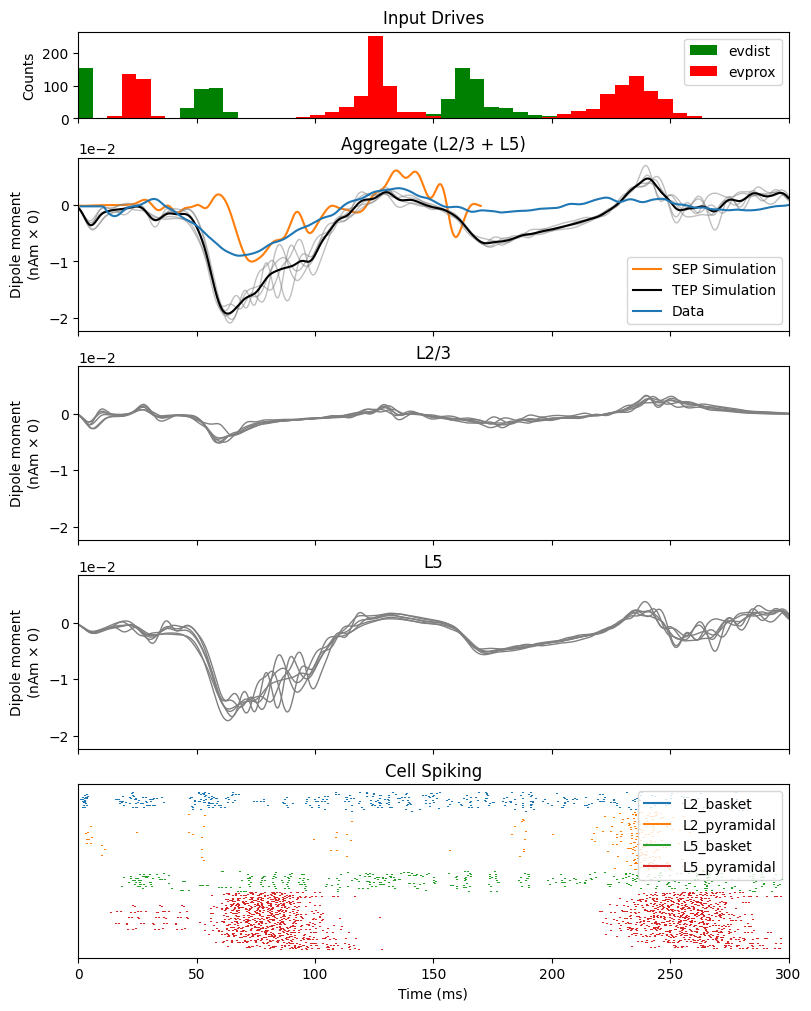

In [12]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 10), constrained_layout=True, height_ratios=[1,2,2,2,2])

# plot 1: drives
v1_nets[0].cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)
axes[0].title.set_text('Input Drives')

# plot 2: dipole, agg and data 
avg_SEP_dpls = deepcopy(smoothed_SEP_dpls[0])
plot_dipole(avg_SEP_dpls, ax = axes[1], layer='agg', show=False, average=True, label='SEP Simulation', color='tab:orange')

avg_v1_dpls = deepcopy(smoothed_v1_dpls[0])
plot_dipole(avg_v1_dpls, ax = axes[1], layer='agg', show=False, average=True, label='TEP Simulation',)
axes[1].plot(np.array(partic_data[0][:300]), np.array(partic_data[1][:300]), label='Data')
axes[1].legend()

ymin, ymax = axes[1].get_ylim()

# plot 3: dipole, layer 2/3
plot_dipole(avg_v1_dpls, ax = axes[2], layer='L2', show=False)
axes[2].set_ylim(ymin, ymax)

# plot 4: dipole, layer 5
plot_dipole(avg_v1_dpls, ax = axes[3], layer='L5', show=False)
axes[3].set_ylim(ymin, ymax)
axes[3].set_xlim(0,300)

# plot 5: cell spiking
v1_nets[0].cell_response.plot_spikes_raster(ax=axes[4], show=False)
axes[4].title.set_text('Cell Spiking')

for ax in axes[:-1]:  # Iterate over all subplots except the last one
    ax.set_xlabel('') 

# fig.suptitle('Hand Tuning')

In [27]:
v3_nets, smoothed_v3_dpls = simulate_from_params([V3_TEP_params], n_trials=5, scaling_factor=0.3)

MPI will run 5 trial(s) sequentially by distributing network neurons over 5 processes.
numprocs=5
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as 

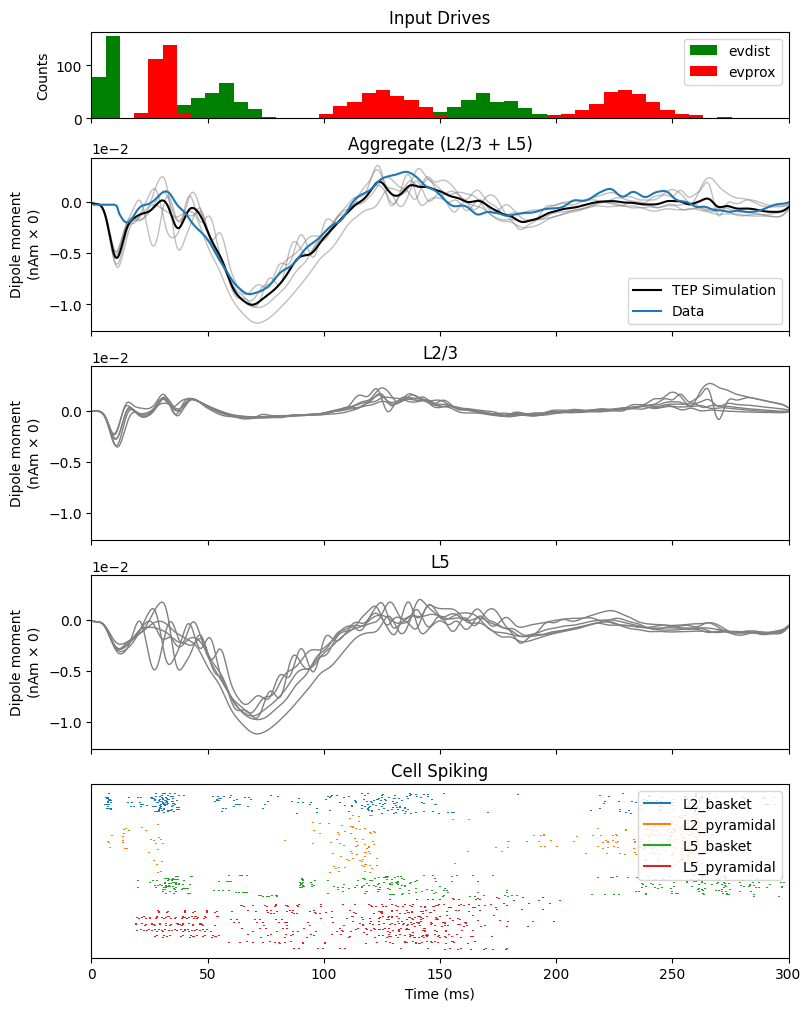

In [29]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 10), constrained_layout=True, height_ratios=[1,2,2,2,2])

# plot 1: drives
v3_nets[0].cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)
axes[0].title.set_text('Input Drives')

# plot 2: dipole, agg and data 
avg_dpls = deepcopy(smoothed_v3_dpls[0])
plot_dipole(avg_dpls, ax = axes[1], layer='agg', show=False, average=True, label='TEP Simulation',)
axes[1].plot(np.array(partic_data[0][:300]), np.array(partic_data[1][:300]), label='Data')
axes[1].legend()

ymin, ymax = axes[1].get_ylim()

# plot 3: dipole, layer 2/3
plot_dipole(avg_dpls, ax = axes[2], layer='L2', show=False)
axes[2].set_ylim(ymin, ymax)

# plot 4: dipole, layer 5
plot_dipole(avg_dpls, ax = axes[3], layer='L5', show=False)
axes[3].set_ylim(ymin, ymax)
axes[3].set_xlim(0,300)

# plot 5: cell spiking
v3_nets[0].cell_response.plot_spikes_raster(ax=axes[4], show=False)
axes[4].title.set_text('Cell Spiking')

for ax in axes[:-1]:  # Iterate over all subplots except the last one
    ax.set_xlabel('') 

# fig.suptitle('Hand Tuning')

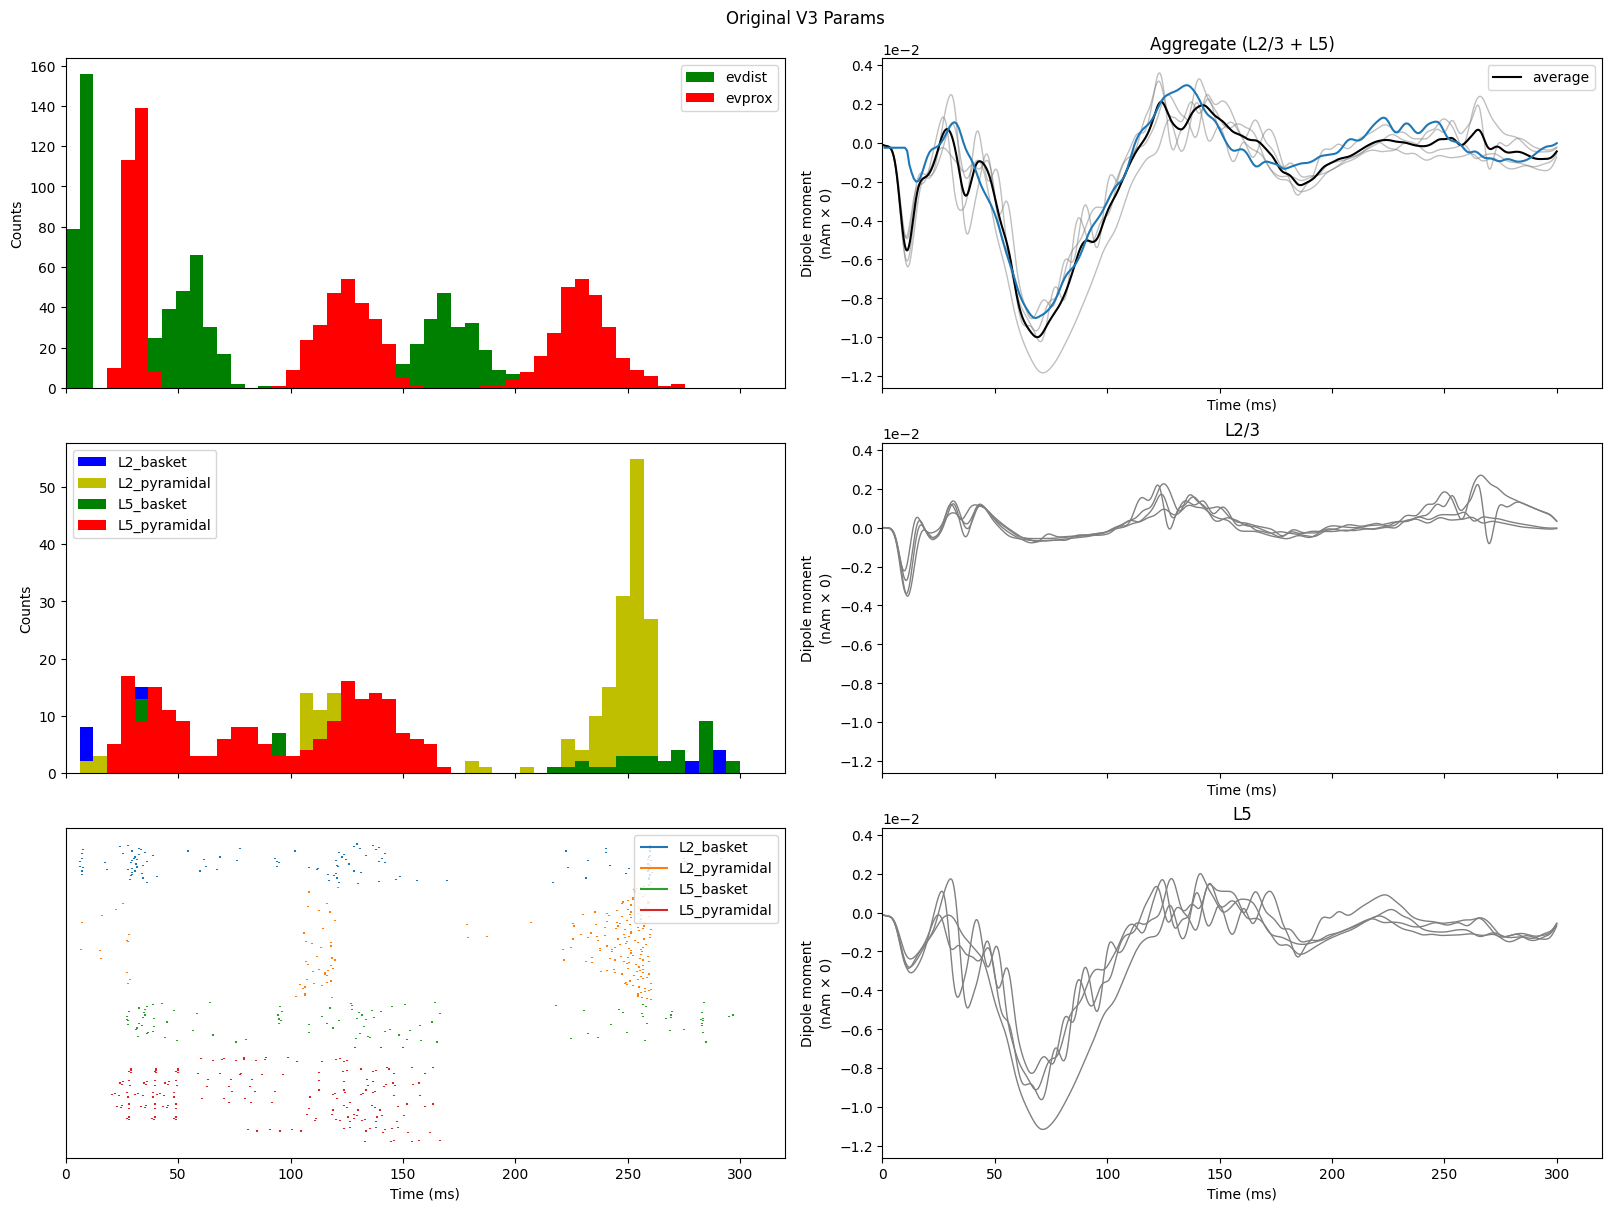

In [41]:
make_plot(smoothed_v3_dpls, v3_nets, [0], title_list=['Original V3 Params'], trial_idx=0, data_scale=1)

In [284]:
V3_TEP_params

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

<h1>Scale down all the drives

In [12]:
TEP_scale_down = deepcopy(V3_TEP_params)

In [21]:
for param in TEP_scale_down['gbar_ev*']:
    TEP_scale_down[param] = TEP_scale_down[param]/3

In [22]:
TEP_scale_down

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [23]:
v3_scaled_down_nets, smoothed_scale_down_v3_dpls = simulate_from_params([TEP_scale_down], n_trials=4)

MPI will run 4 trial(s) sequentially by distributing network neurons over 4 processes.
numprocs=4
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/h

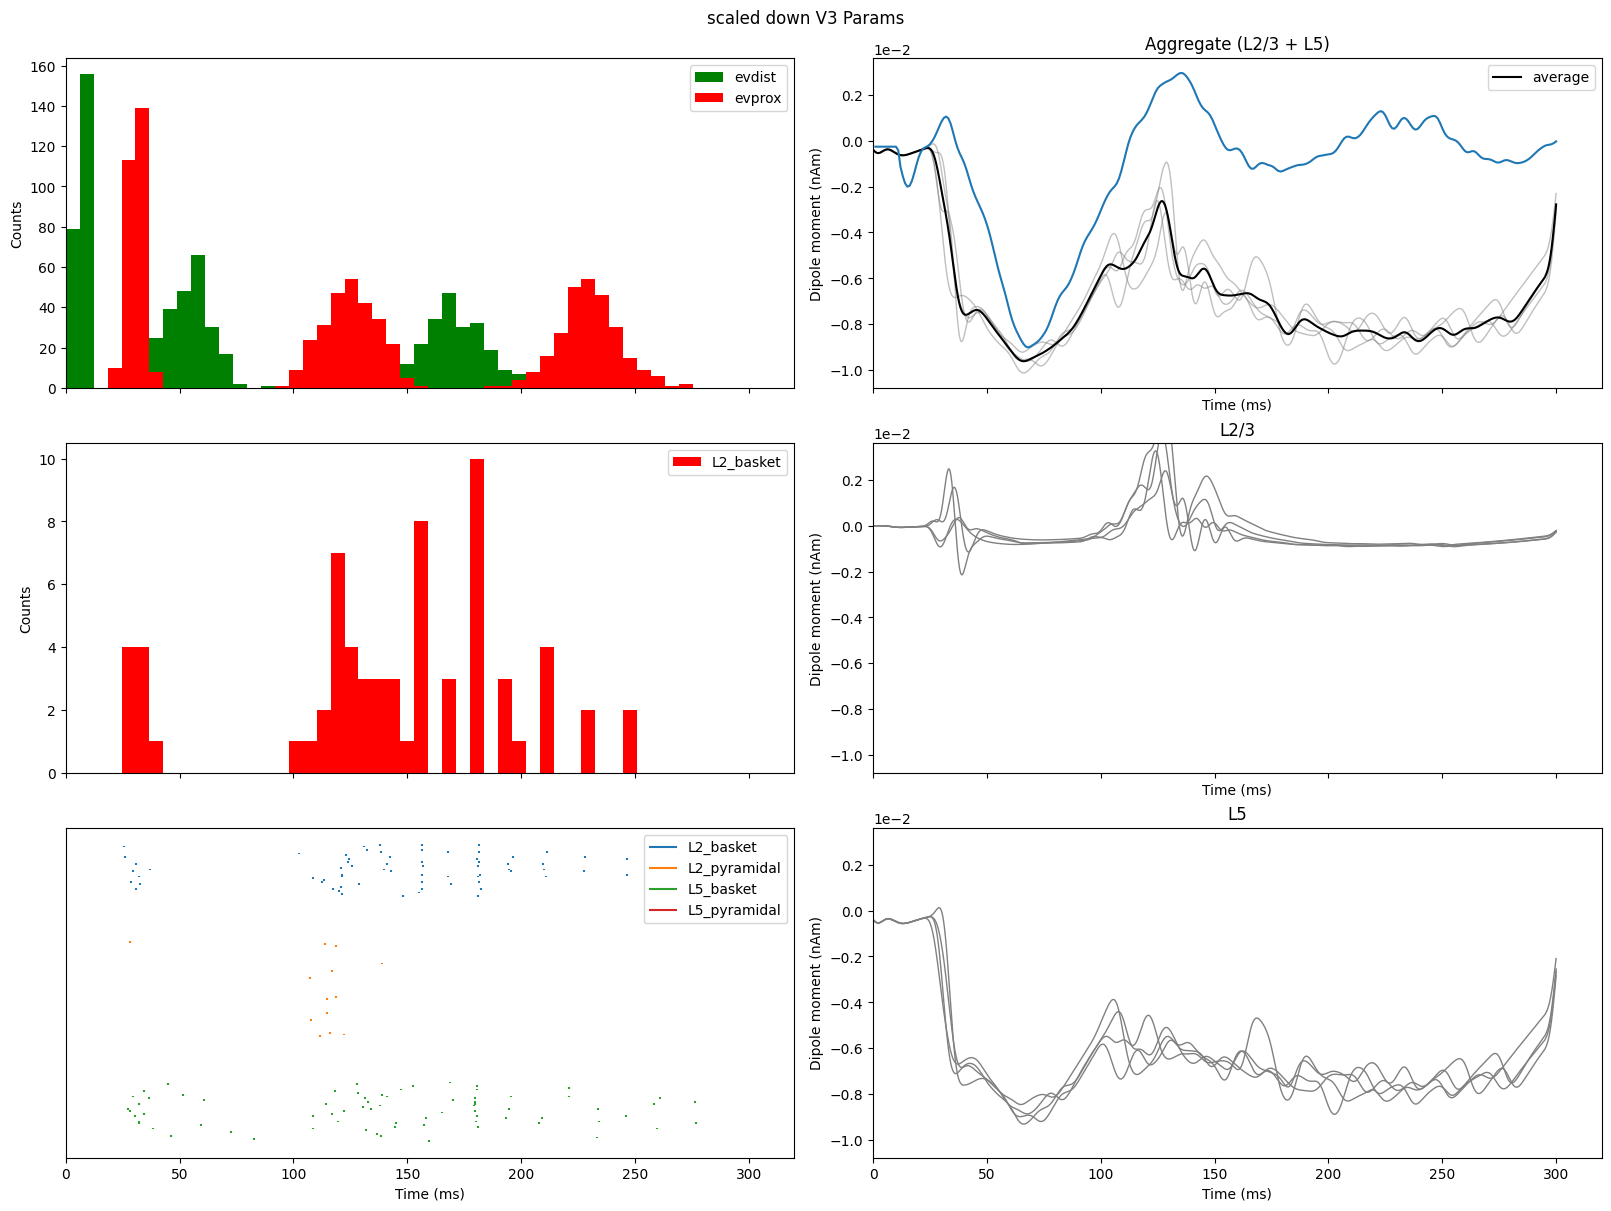

In [24]:
make_plot(smoothed_scale_down_v3_dpls, v3_scaled_down_nets, [0], title_list=['scaled down V3 Params'], trial_idx=0, data_scale=1)

<h1>Reduce Dist1

In [278]:
# scale down the dist_1 drives 
dist_1_scalars = [0.7, 0.5]

dist1_params_list = [deepcopy(V3_TEP_params) for _ in range(len(dist_1_scalars))]

for params, scalar in zip(dist1_params_list, dist_1_scalars):
    params['t_evdist_2'] = params['t_evdist_2']-6
    for param in params['gbar_evdist_2*']:
        params[param] = scalar * params[param]

print(dist1_params_list[0]['t_evdist_2'])  
print(dist1_params_list[1]['gbar_evdist_2*'])   

0.5284849999999999
{
    "gbar_evdist_2_L2Basket_ampa": 0.0012370859999999999,
    "gbar_evdist_2_L2Basket_nmda": 0.019607562,
    "gbar_evdist_2_L2Pyr_ampa": 0.0015730019999999998,
    "gbar_evdist_2_L2Pyr_nmda": 0.002071854,
    "gbar_evdist_2_L5Pyr_ampa": 0.015415865999999999,
    "gbar_evdist_2_L5Pyr_nmda": 0.0030042719999999997
}


In [279]:
dist1_params_list[1]

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [280]:
dist1_nets, smoothed_dist1_dpls = simulate_from_params(dist1_params_list)

MPI will run 2 trial(s) sequentially by distributing network neurons over 2 processes.
numprocs=2
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
T

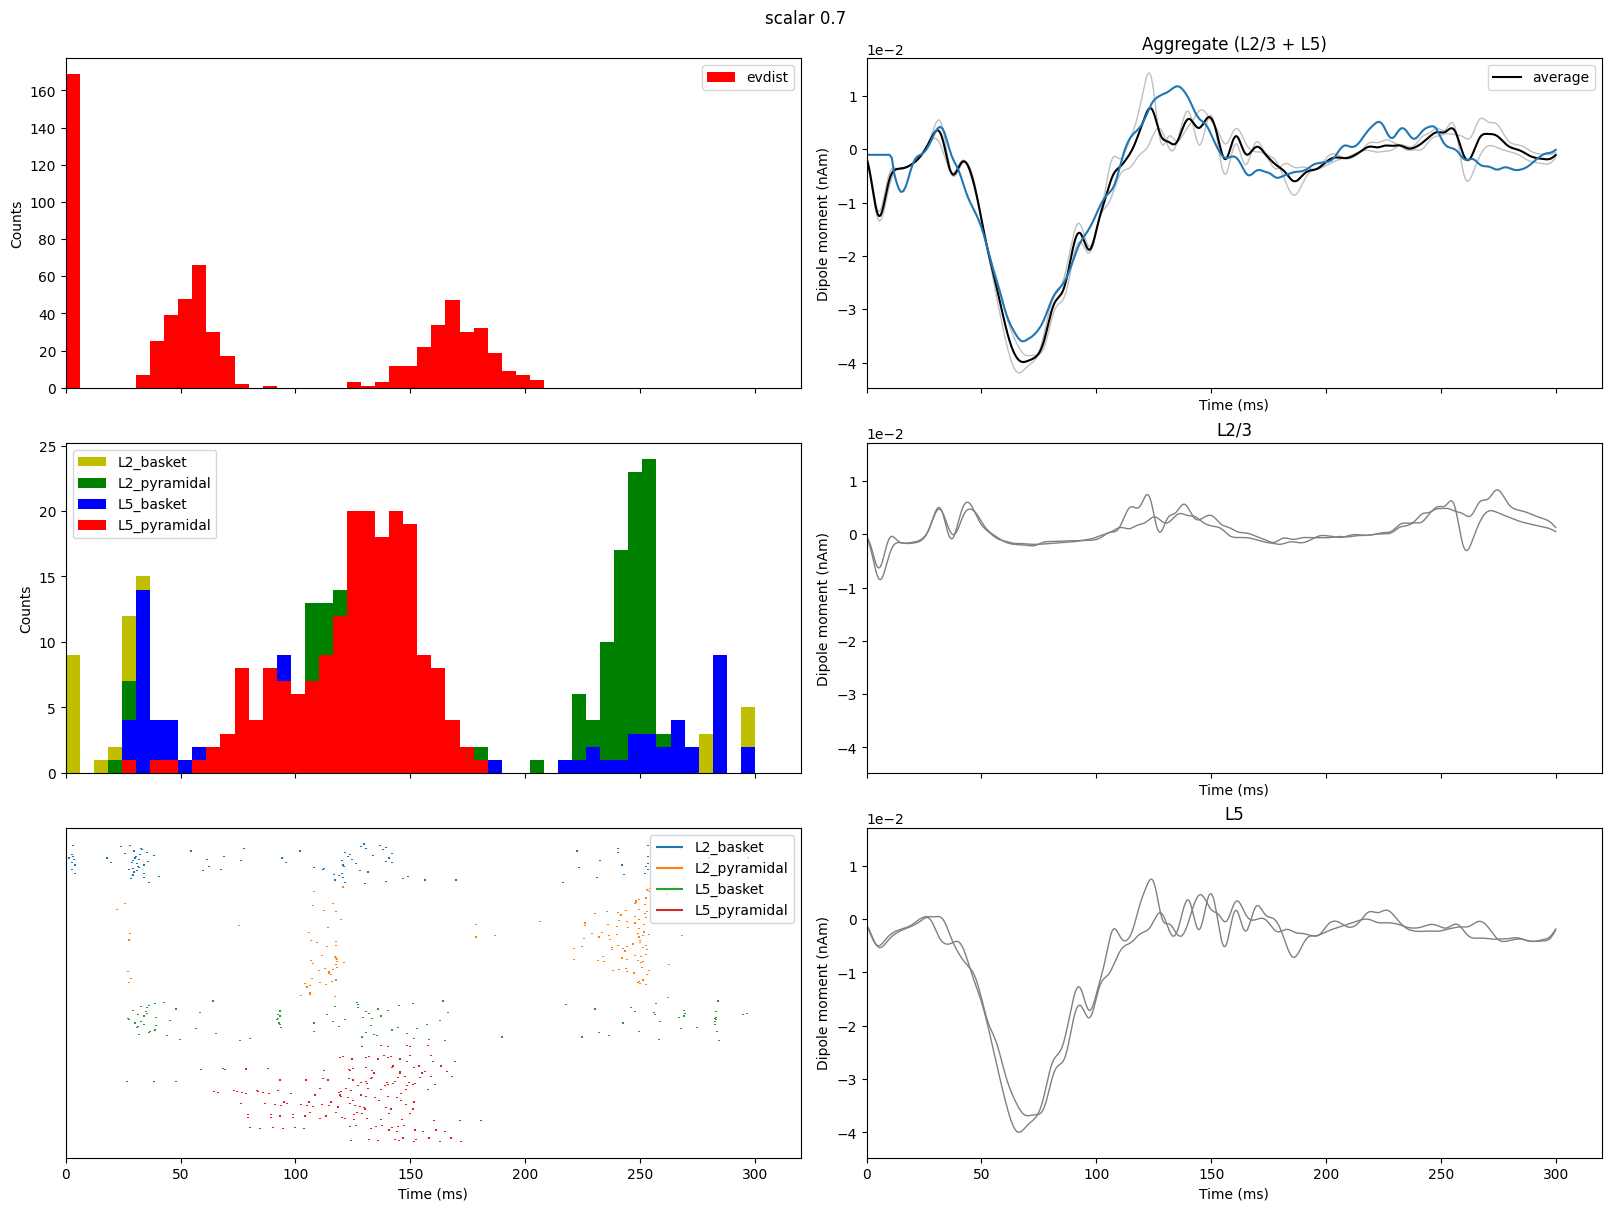

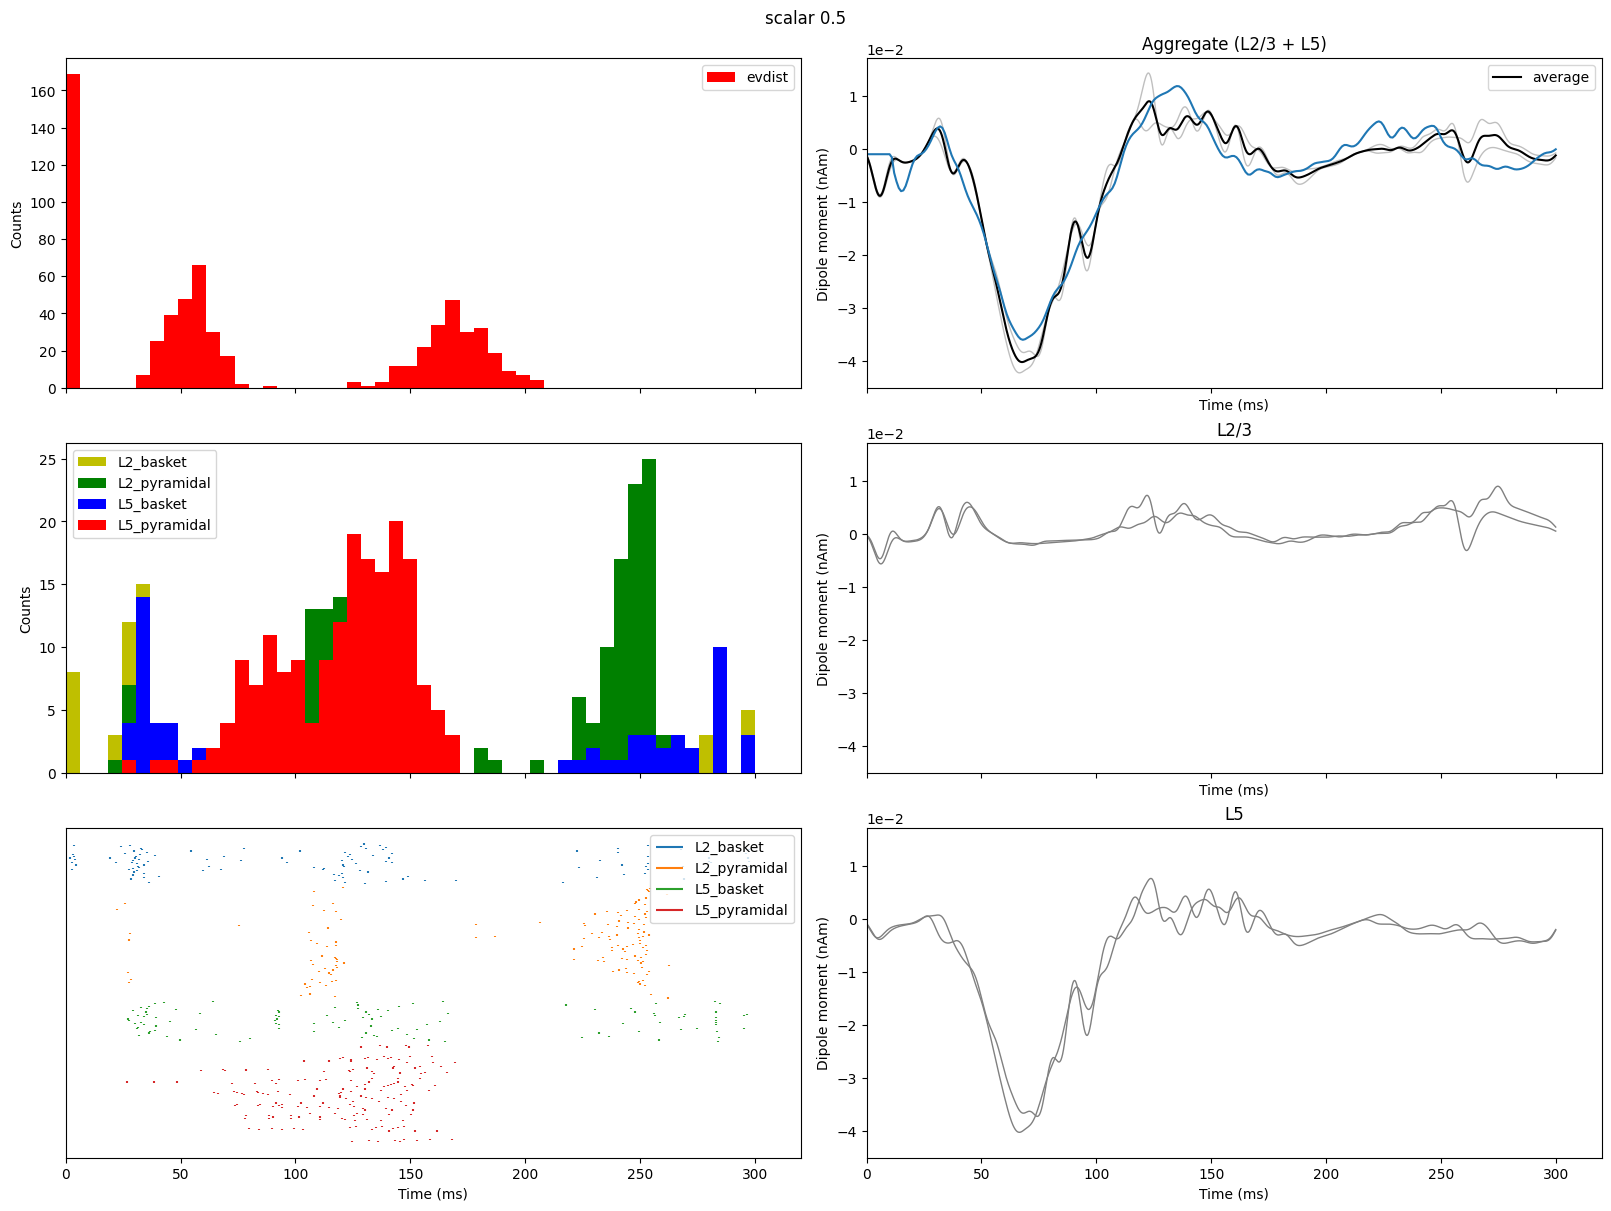

In [281]:
make_plot(smoothed_dist1_dpls, dist1_nets, dist_1_scalars)

In [38]:
with open(f'param_files/net_TEP_calcium_params_v4.pkl', 'wb') as file:
    pickle.dump(dist1_params_list[1], file)

<h1>Move Dist1 drive time earlier

In [267]:
# remove prox1 drives 

dist1_t_params_list = deepcopy(V3_TEP_params) 

# for params in dist1_t_params_list:
dist1_t_params_list['t_evdist_2'] = dist1_t_params_list['t_evdist_2'] - 6

print(dist1_t_params_list['t_evdist_2'])  
# print(dist1_t_params_list[1]['t_evdist_2'])   

0.5284849999999999


In [268]:
dist1_t_params_list

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [269]:
dist1_t_nets, smoothed_dist1_t_dpls = simulate_from_params([dist1_t_params_list],n_trials=4)

MPI will run 4 trial(s) sequentially by distributing network neurons over 4 processes.
numprocs=4
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/h

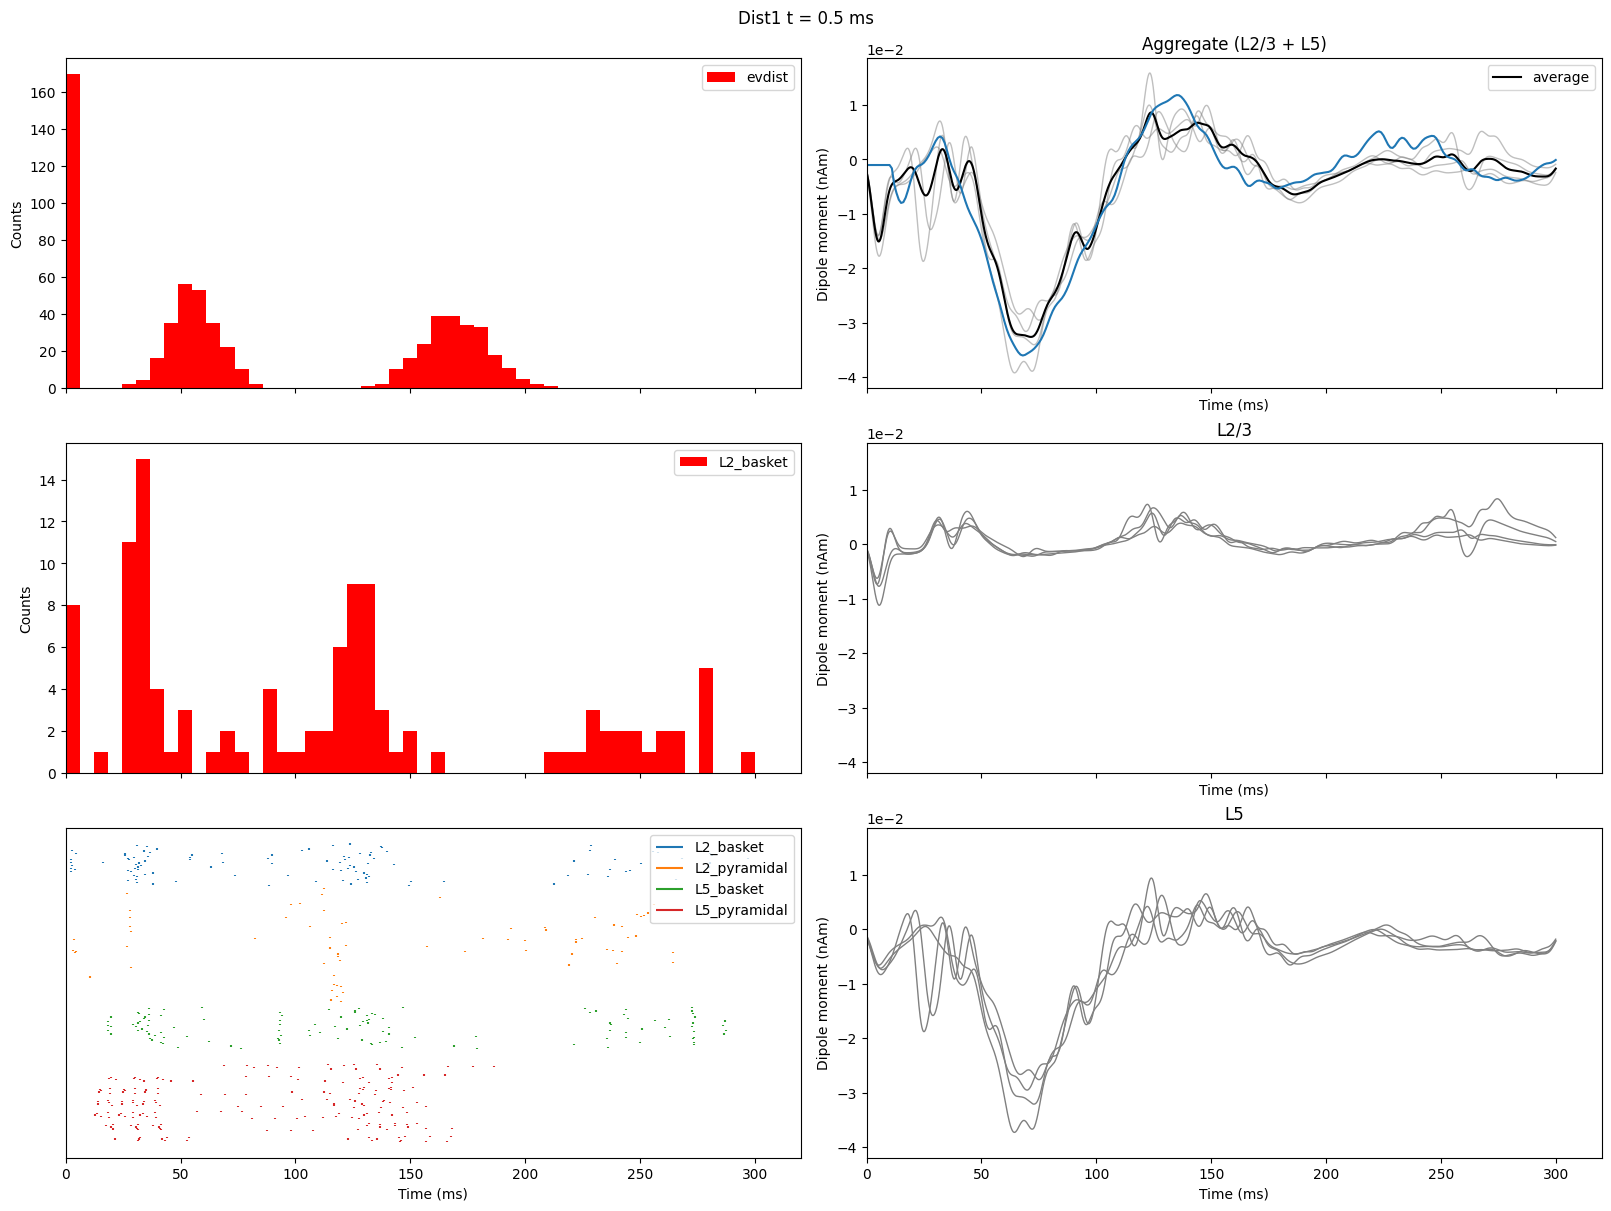

In [271]:
make_plot(smoothed_dist1_t_dpls, dist1_t_nets, dist_1_scalars, title_list=['Dist1 t = 0.5 ms'], trial_idx=2)

<h1> Increase SD of dist1

In [265]:
# increase sd dist1
dist1_sd_params = deepcopy(dist1_t_params_list) 

# for params in dist1_t_params_list:
# dist1_sd_params['sigma_t_evdist_2'] = dist1_sd_params['sigma_t_evdist_2'] + 2
dist1_sd_params['t_evdist_2'] = dist1_sd_params['t_evdist_2'] +1

print(dist1_sd_params['t_evdist_2'])  
# print(dist1_t_params_list[1]['t_evdist_2'])  

1.5284849999999999


In [266]:
dist1_sd_nets, smoothed_dist1_sd_dpls = simulate_from_params([dist1_sd_params], n_trials=4)

MPI will run 4 trial(s) sequentially by distributing network neurons over 4 processes.
numprocs=4
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/h

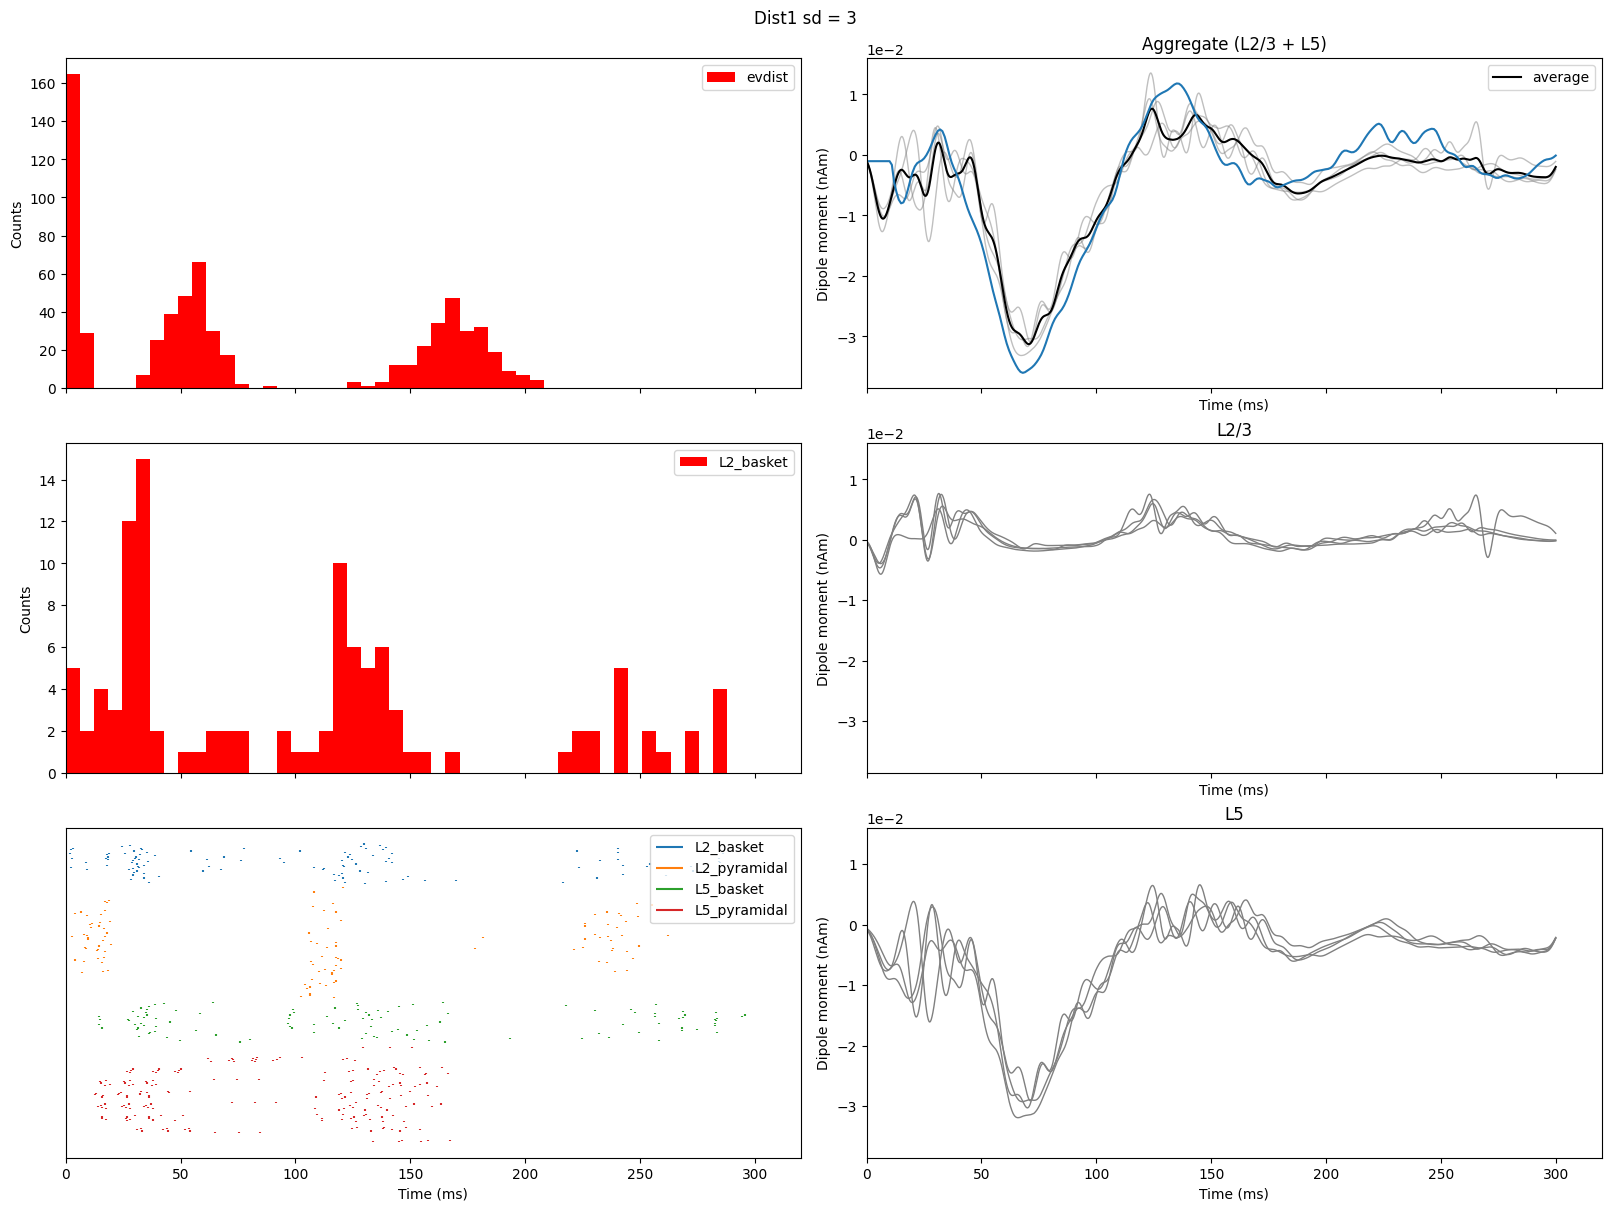

In [263]:
make_plot(smoothed_dist1_sd_dpls, dist1_sd_nets, dist_1_scalars, title_list=['Dist1 sd = 3'])

In [141]:
with open(f'param_files/net_TEP_calcium_params_v4.pkl', 'wb') as file:
    pickle.dump(dist1_t_params_list[0], file)

In [294]:
V3_TEP_params

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

<h1>Just the first distal drive + prox1

In [13]:
dist1_net = calcium_model()

scale = 0.5

weights_ampa_d1 = {'L2_basket': 0.0024741719999999997 * scale, 'L2_pyramidal': 0.0031460039999999996 * scale,
                   'L5_pyramidal': 0.030831731999999997 * scale}
weights_nmda_d1 = {'L2_basket': 0.039215124 * scale, 'L2_pyramidal': 0.004143708 * scale,
                   'L5_pyramidal': 0.006008543999999999 * scale}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
dist1_net.add_evoked_drive(
    'evdist1', mu=6.528485, sigma=1.0040786, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal',
    synaptic_delays=synaptic_delays_d1, event_seed=0)



# weights_ampa_p1 = {'L2_basket': 3.1877600000000004, 'L2_pyramidal': 0.17786000000000002,
#                    'L5_pyramidal': 0.0073, 'L5_basket': 6.059539999999999}
# synaptic_delays_p1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
#                       'L5_pyramidal': 1.0, 'L5_basket':1.0}
# dist1_net.add_evoked_drive(
#     'evprox1', mu=30.472788, sigma=3.154862, numspikes=1, weights_ampa=weights_ampa_p1,
#     weights_nmda=None, location='proximal',
#     synaptic_delays=synaptic_delays_p1, event_seed=4)

with MPIBackend(n_procs=3, mpi_cmd='mpiexec'):
    dpl = simulate_dipole(dist1_net, tstop=300, n_trials=3)

    # "gbar_evprox_1_L2Basket_ampa": 3.1877600000000004,
    # "gbar_evprox_1_L2Basket_nmda": 0.0,
    # "gbar_evprox_1_L2Pyr_ampa": 0.17786000000000002,
    # "gbar_evprox_1_L2Pyr_nmda": 0.0,
    # "gbar_evprox_1_L5Basket_ampa": 6.059539999999999,
    # "gbar_evprox_1_L5Basket_nmda": 0.0,
    # "gbar_evprox_1_L5Pyr_ampa": 0.0073,
    # "gbar_evprox_1_L5Pyr_nmda": 0.0,

MPI will run 3 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

In [14]:

smoothed_dpls = scale_and_smooth([dpl], scaling_factor=0.3, window_len=10)

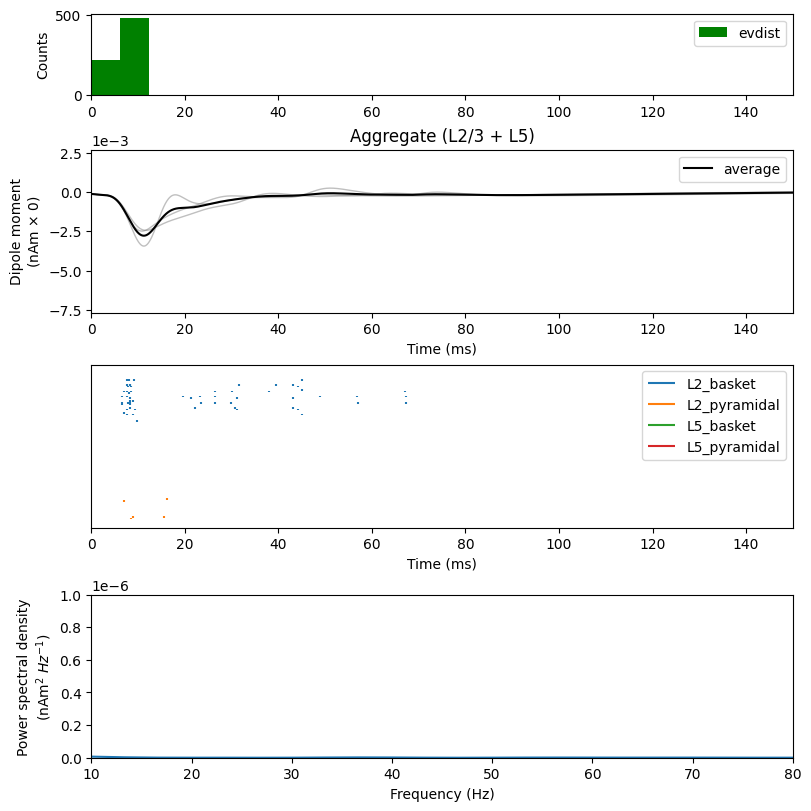

Text(0.5, 0.98, 'Weak 1st Distal input only')

In [15]:
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(8, 8), constrained_layout=True, height_ratios=[1,2,2,2])

# plot 1: drives
dist1_net.cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evdist'], show=False, color='g')
axes[0].set_xlim(0,150)

# plot 2: dipole, agg and data 
avg_dpls = deepcopy(smoothed_dpls)
plot_dipole(avg_dpls[0], ax = axes[1], layer='agg', show=False, average=True)
# axes[1].plot(np.array(partic_data[0][:150]), np.array(partic_data[1][:150]))
axes[1].set_ylim(-7.7e-3,2.7e-3)
axes[1].set_xlim(0,150)

# plot 3: cell spiking
dist1_net.cell_response.plot_spikes_raster(ax=axes[2], show=False)
axes[2].set_xlim(0,150)

# plot 4: psd
axes[3].set_ylim(0,1e-6)
dpl[0].plot_psd(fmin=10, fmax=80, ax=axes[3])

# dist1_net.cell_response.plot_spikes_raster(ax=axes[3], show=False)
    

fig.suptitle('Weak 1st Distal input only')

In [75]:
dist1_net.external_drives

{'evdist1': <External drive 'evdist1'
 drive class: evoked
 target location: distal
 target cell types: ['L2_basket', 'L2_pyramidal', 'L5_pyramidal']
 number of drive cells: 235
 cell-specific: True
 dynamic parameters:
 	mu: 0.528485
 	sigma: 1.0040786
 	numspikes: 1
 event times instantiated for 3 trials>}

<h1>Try LFP

In [8]:
with open('sim_data/net_opt_calcium_TEP.pkl', 'rb') as f:
    opt_net = pickle.load(f)

In [209]:
dist1_t_params_list[0]

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [ ]:
V3_TEP_params

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [ ]:
V4_net = deepcopy(dist1_t_nets[0])

In [150]:
V3_net = calcium_model(params=V3_TEP_params, add_drives_from_params=True)

In [10]:
net = opt_net

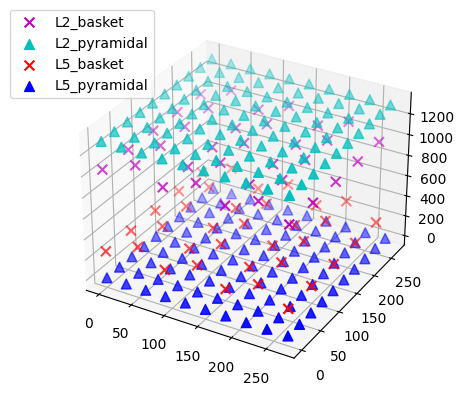

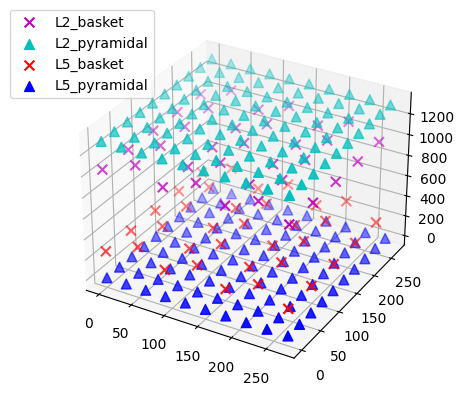

In [11]:
import matplotlib.pyplot as plt
net.set_cell_positions(inplane_distance=30.)
net.plot_cells()

In [12]:
depths = list(range(-325, 2150, 100))
electrode_pos = [(135, 135, dep) for dep in depths]
net.add_electrode_array('shank1', electrode_pos)

{'shank1': <ExtracellularArray | 25 electrodes, conductivity=0.3, method=psa | 1 trials, 12001 times>}


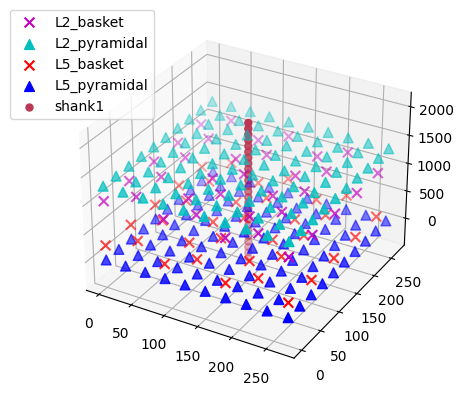

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...


In [25]:
print(net.rec_arrays)
net.plot_cells()

dpl = simulate_dipole(net, tstop=300, record_vsec='all', n_trials=1)

In [26]:
gid_ranges = net.gid_ranges
print(net.gid_ranges)


OrderedDict([('L2_basket', range(0, 35)), ('L2_pyramidal', range(35, 135)), ('L5_basket', range(135, 170)), ('L5_pyramidal', range(170, 270)), ('evprox1', range(270, 540)), ('evprox2', range(540, 810)), ('evprox3', range(810, 1080)), ('evdist1', range(1080, 1315)), ('evdist2', range(1315, 1550)), ('evdist3', range(1550, 1785))])


In [27]:
trial_idx = 0
vsec = net.cell_response.vsec[trial_idx]
print(vsec.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

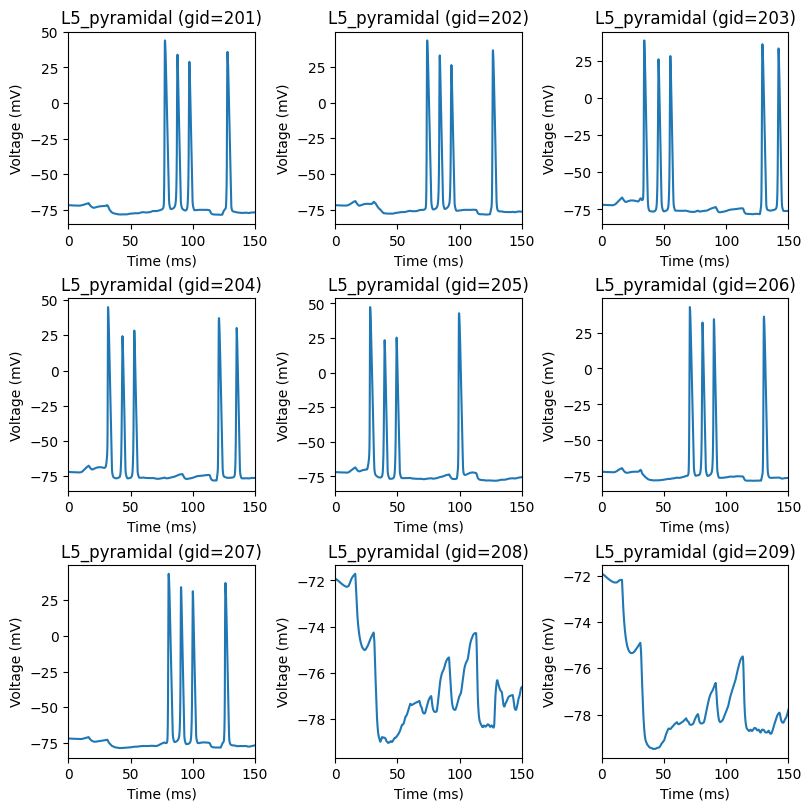

In [32]:
import random 
gids = [201, 202, 203, 204, 205, 206, 207, 208, 209]
# gids = random.sample(range(170, 270), 9)
fig, axes = plt.subplots(3, 3, figsize=(8, 8), constrained_layout=True)

for ax, gid in zip(axes.flat, gids):
    ax.plot(net.cell_response.times, vsec[gid]['soma'])
    ax.set_title('%s (gid=%d)'%(net.gid_to_type(gid), gid))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (mV)')
    ax.set_xlim(0, 150)

plt.show()

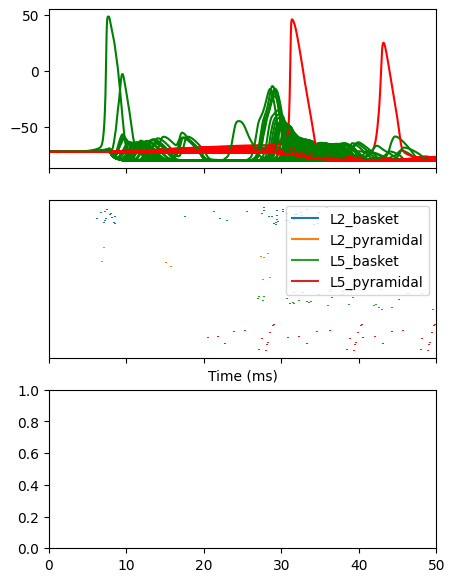

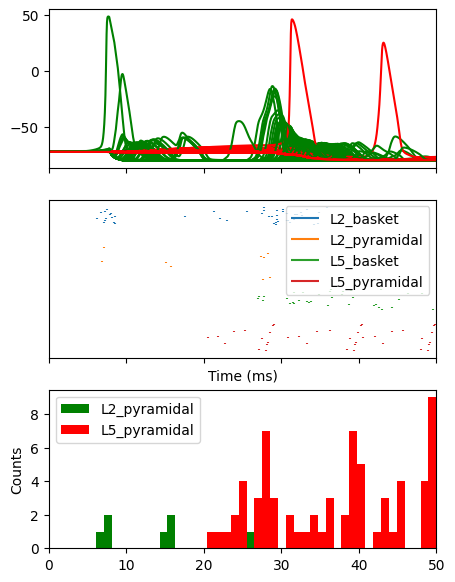

In [322]:
fig, axes = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

for idx in range(100):  # only 10 cells per cell-type
    gid = gid_ranges['L2_pyramidal'][idx]
    axes[0].plot(net.cell_response.times, vsec[gid]['soma'], color='g')
    gid = gid_ranges['L5_pyramidal'][idx]
    axes[0].plot(net.cell_response.times, vsec[gid]['soma'], color='r')
net.cell_response.plot_spikes_raster(ax=axes[1])
net.cell_response.plot_spikes_hist(ax=axes[2],
                                   spike_types=['L5_pyramidal',
                                                'L2_pyramidal'], show=True)

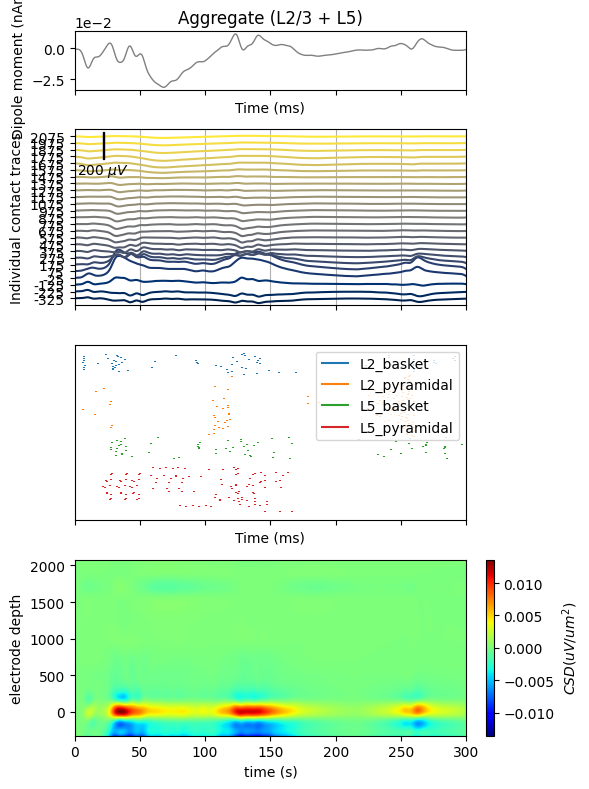

In [154]:
trial_idx = 0
window_len = 10  # ms
decimate = [5, 4]  # from 40k to 8k to 2k
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(6, 8),
                        gridspec_kw={'height_ratios': [1, 3, 3, 3]})

# Then plot the aggregate dipole time series on its own axis
dpl[trial_idx].smooth(window_len=window_len)
dpl[trial_idx].plot(ax=axs[0], decim=decimate, show=False)

# use the same smoothing window on the LFP traces to allow comparison to dipole
V3_net.rec_arrays['shank1'][trial_idx].smooth(window_len=window_len).plot_lfp(
    ax=axs[1], decim=decimate, show=False)

axs[1].grid(True, which='major', axis='x')
axs[1].set_xlabel('')
# Add spike raster to subplot
V3_net.cell_response.plot_spikes_raster(ax=axs[2], show=False)

# Finally, add the CSD to the bottom subplot
V3_net.rec_arrays['shank1'][trial_idx].smooth(window_len=window_len).plot_csd(ax=axs[3], show=False)
plt.tight_layout()
plt.show()